<a href="https://colab.research.google.com/github/SisekoC/OpenCV/blob/main/Toxic_Comment_Classification_Multi_Label_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dataset Description

You are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

## Import Modules

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, classification_report

import warnings
warnings.filterwarnings('ignore')

## Load the Dataset

In [11]:
df = pd.read_csv('train.csv')
df.head(15)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [12]:
# dataset stats
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
# dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [14]:
# check for null values
df.isnull().sum()

,0
id,0
comment_text,0
toxic,0
severe_toxic,0
obscene,0
threat,0
insult,0
identity_hate,0


In [15]:
len(df)

159571

## Exploratory Data Analysis

In [16]:
x = df.iloc[:, 2:].sum() # take only label columns
x

,0
toxic,15294
severe_toxic,1595
obscene,8449
threat,478
insult,7877
identity_hate,1405


In [17]:
rowsums = df.iloc[:, 2:].sum(axis=1) # take label columns and sum it column wise
rowsums

,0
0,0
1,0
2,0
3,0
4,0
...,...
159566,0
159567,0
159568,0
159569,0


In [18]:
no_label_count = 0

for i, count in rowsums.items():
    if count==0:
        no_label_count += 1

print('Total number of comments:', len(df))
print('Total number of comments without labels:', no_label_count)
print('Total labels:', x.sum())

Total number of comments: 159571
Total number of comments without labels: 143346
Total labels: 35098


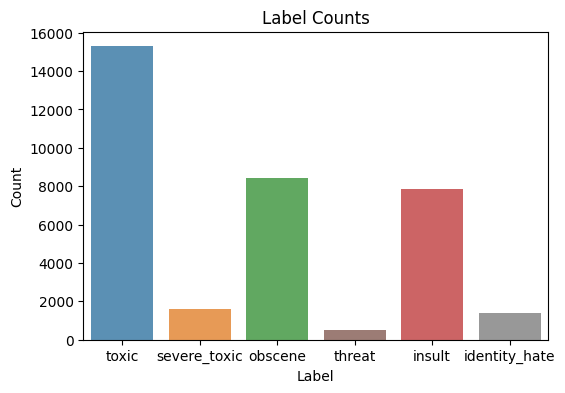

In [19]:
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:red', 'tab:grey'])
plt.title('Label Counts')
plt.ylabel('Count')
plt.xlabel('Label')

plt.show()

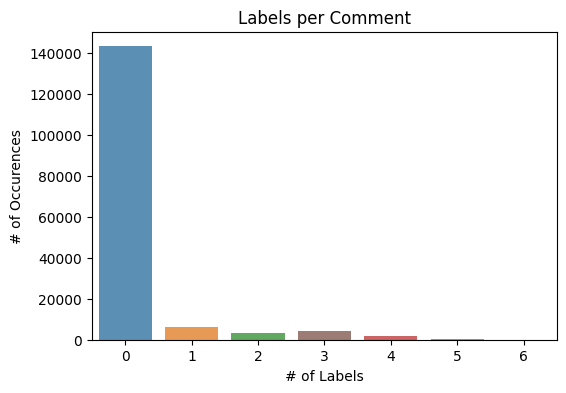

In [20]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=rowsums.values, alpha=0.8, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:red', 'tab:grey'])
plt.title('Labels per Comment')
plt.ylabel('# of Occurences')
plt.xlabel('# of Labels')

plt.show()

## Data Preprocessing

In [21]:
df = df.drop(columns=['id'], axis=1)
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
# remove stopwords
stopwords = set(stopwords.words('english'))

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stopwords]
    return " ".join(no_stopword_text)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

# stemming
stemmer = SnowballStemmer('english')
def stemming(sentence):
    stemmed_sentence = ""
    for word in sentence.split():
        stemmed_word = stemmer.stem(word)
        stemmed_sentence += stemmed_word + " "

    stemmed_sentence = stemmed_sentence.strip()
    return stemmed_sentence

In [25]:
# preprocess the comment
df['comment_text'] = df['comment_text'].apply(lambda x: remove_stopwords(x))
df['comment_text'] = df['comment_text'].apply(lambda x: clean_text(x))
df['comment_text'] = df['comment_text'].apply(lambda x: stemming(x))
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explan whi edit made usernam hardcor metallica...,0,0,0,0,0,0
1,d aww he match background colour i am seem stu...,0,0,0,0,0,0
2,hey man i am realli tri edit war it guy consta...,0,0,0,0,0,0
3,more i can not make real suggest improv i wond...,0,0,0,0,0,0
4,you sir hero ani chanc rememb page that on,0,0,0,0,0,0


In [26]:
# split input and output
X = df['comment_text']
y = df.drop(columns=['comment_text'], axis=1)

In [27]:
# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
def run_pipeline(pipeline, X_train, X_test, y_train, y_test):
    # train model
    pipeline.fit(X_train, y_train)
    # predict from model
    predictions = pipeline.predict(X_test)
    pred_probs = pipeline.predict_proba(X_test)
    # print metrics
    print('roc_auc:', roc_auc_score(y_test, pred_probs))
    print('accuracy:', accuracy_score(y_test, predictions))
    print('classification report')
    print(classification_report(y_test, predictions, target_names=y_train.columns))

In [29]:
NB_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('nb_model', OneVsRestClassifier(MultinomialNB(), n_jobs=-1))
])

LR_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('nb_model', OneVsRestClassifier(LogisticRegression(), n_jobs=-1))
])

In [30]:
run_pipeline(NB_pipeline, X_train, X_test, y_train, y_test)

roc_auc: 0.8604178106899295
accuracy: 0.8997963340122199
classification report
               precision    recall  f1-score   support

        toxic       0.99      0.19      0.32      3056
 severe_toxic       0.00      0.00      0.00       321
      obscene       0.98      0.11      0.20      1715
       threat       1.00      0.01      0.03        74
       insult       0.97      0.05      0.10      1614
identity_hate       0.00      0.00      0.00       294

    micro avg       0.98      0.12      0.22      7074
    macro avg       0.66      0.06      0.11      7074
 weighted avg       0.90      0.12      0.21      7074
  samples avg       0.02      0.01      0.01      7074



In [31]:
run_pipeline(LR_pipeline, X_train, X_test, y_train, y_test)

roc_auc: 0.9794842342013226
accuracy: 0.9187216042613191
classification report
               precision    recall  f1-score   support

        toxic       0.91      0.62      0.74      3056
 severe_toxic       0.58      0.28      0.38       321
      obscene       0.92      0.64      0.75      1715
       threat       0.69      0.15      0.24        74
       insult       0.81      0.51      0.62      1614
identity_hate       0.72      0.16      0.26       294

    micro avg       0.88      0.56      0.68      7074
    macro avg       0.77      0.39      0.50      7074
 weighted avg       0.87      0.56      0.67      7074
  samples avg       0.06      0.05      0.05      7074



## Test Prediction

In [32]:
labels = y_train.columns.values
labels

array(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'], dtype=object)

In [33]:
X_test.sample(1).values[0]

'yeah help my exampl someon want clone databas want link articl order conform gfdl the link provid attribut author articl delet content longer attribut gfdl violat talk'

In [34]:
sentence = 'hello dick wikipedia fuckwhit ban'
stemmed_sentence = stemming(sentence)
results = LR_pipeline.predict([stemmed_sentence])[0]
for label, result in zip(labels, results):
    print("%14s %5s" % (label, result))

         toxic     1
  severe_toxic     0
       obscene     1
        threat     0
        insult     0
 identity_hate     0


In [35]:
sentence = 'hello how are you doing'
stemmed_sentence = stemming(sentence)
results = LR_pipeline.predict([stemmed_sentence])[0]
for label, result in zip(labels, results):
    print("%14s %5s" % (label, result))

         toxic     0
  severe_toxic     0
       obscene     0
        threat     0
        insult     0
 identity_hate     0


## ROC Curve

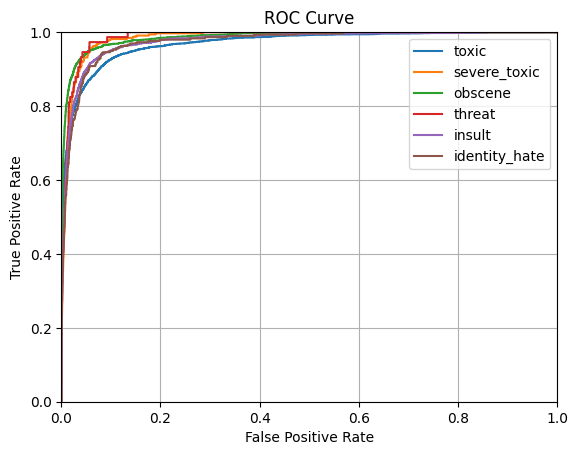

In [36]:
def plot_roc_curve(test_labels, predict_prob):
    fpr, tpr, thresholds = roc_curve(test_labels, predict_prob)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.legend(labels)

def plot_pipeline_roc_curve(pipeline, X_train, X_test, y_train, y_test):
    for label in labels:
        pipeline.fit(X_train, y_train[label])
        pred_probs = pipeline.predict_proba(X_test)[:, 1]
        plot_roc_curve(y_test[label], pred_probs)

plot_pipeline_roc_curve(LR_pipeline, X_train, X_test, y_train, y_test)